In this notebook we simulate rounded pentagons using the [DEM component](https://hoomd-blue.readthedocs.io/en/stable/module-dem-pair.html#hoomd.dem.pair.WCA) of HOOMD-Blue. We visualize the shapes using the matplotlib backend and color them by their orientation.

In [1]:
import flowws
import gtar
from hoomd_flowws.Init import Init
from hoomd_flowws.DEMInteraction import DEMInteraction
from hoomd_flowws.Run import Run
from hoomd_flowws.ShapeDefinition import ShapeDefinition

import json
import plato, plato.draw.matplotlib as draw
import freud
import numpy as np
import IPython
import ipywidgets

In [2]:
shape = dict(type='regular_ngon', n=5,
             modifications=[dict(type='scale', factor=2), dict(type='round', radius=.5)])

storage = flowws.DirectoryStorage()
stages = [
    ShapeDefinition(shape_arguments=[shape]),
    Init(number=128),
    DEMInteraction(type='wca'),
    Run(steps=1e3, integrator='langevin'),
    Run(steps=1e5, integrator='langevin', compress_to=.9, dump_period=1e4),
]

flowws.Workflow(stages, storage).run();

HOOMD-blue v2.9.3 CUDA (11.1) DOUBLE HPMC_MIXED SSE SSE2 
Compiled: 10/19/2020
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, J Glaser, and S C Glotzer. "HOOMD-blue: A Python package for
  high-performance molecular dynamics and hard particle Monte Carlo
  simulations", Computational Materials Science 173 (2020) 109363
-----
-----
You are using DEM. Please cite the following:
* M Spellings, R L Marson, J A Anderson, and S C Glotzer. "GPU accelerated
  Discrete Element Method (DEM) molecular dynamics for conservative, faceted
  particle simulations",  Journal of Computational Physics 334 (2017) 460--467
-----
-----
You are using HPMC. Please cite the following:
* J A Anderson, M E Irrgang, and S C Glotzer. "Scalable Metropolis Monte Carlo
  for simulation of hard shapes", Computer Physics Communications 204 (2016) 21
  --30
-----
HOOMD-blue is running on the following GPU(s):
 [0]      GeForce

In [3]:
num_frames = 0

def get_frame(frame=-1):
    global num_frames
    with gtar.GTAR('dump.sqlite', 'r') as traj:
        (posRec, quatRec, boxRec), frames = traj.framesWithRecordsNamed(['position', 'orientation', 'box'])

        for (_, type_shapes) in traj.recordsNamed('type_shapes.json'):
            type_shapes = json.loads(type_shapes)

        num_frames = len(frames)
        positions = traj.getRecord(posRec, frames[frame])
        orientations = traj.getRecord(quatRec, frames[frame])
        box = traj.getRecord(boxRec, frames[frame])

    shapedef = type_shapes[0]
    return positions, orientations, box, shapedef

/home/matthew/dev/plato/plato/draw/matplotlib/Scene.py:111: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  return figure.savefig(filename, dpi=figure.dpi, bbox_inches='tight',
/home/matthew/env/default_20191211/lib/python3.8/site-packages/IPython/core/pylabtools.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


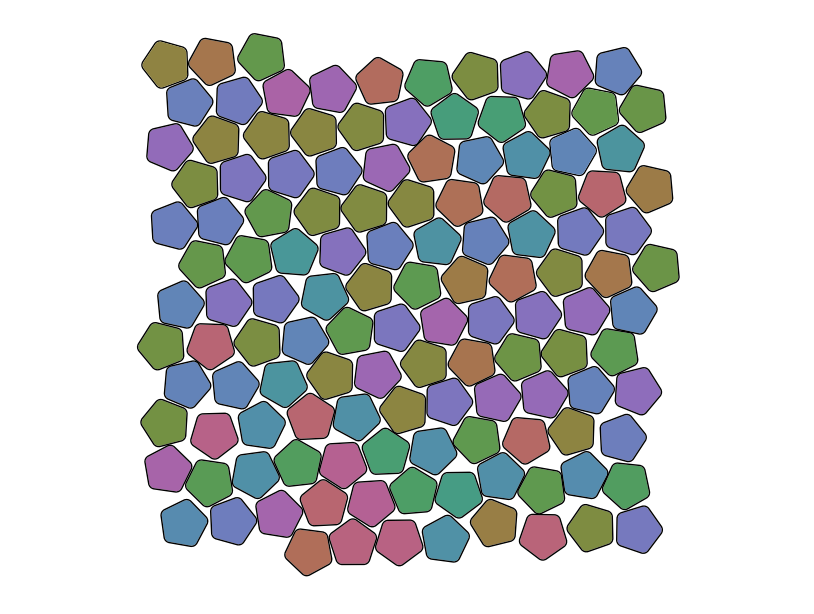

In [4]:
def update(scene, frame=-1):
    (positions, orientations, box, shapedef) = get_frame(frame)
    # orientation angle
    theta = 2*np.arccos(orientations[:, 0])
    colors = np.ones((len(positions), 4))
    colors[:, :3] = plato.cmap.cubeellipse(5*theta)

    for prim in scene:
        prim.positions = positions[:, :2]
        prim.orientations = orientations
        prim.colors = colors
        prim.vertices = shapedef['vertices']
        prim.radius = shapedef['rounding_radius']

prim = draw.Spheropolygons(outline=.1)
scene = draw.Scene(prim, zoom=.7)
update(scene)

target = '../../gallery/flowws_pentagons_matplotlib.png'
scene.save(target)

In [5]:
import plato.draw.vispy as interactive

live_scene = scene.convert(interactive)
live_scene.show()

@ipywidgets.interact(frame=(0, num_frames - 1))
def plot(frame=0):
    update(live_scene, frame)
    live_scene.render()

VispyWidget(height=600, width=800)

interactive(children=(IntSlider(value=0, description='frame', max=9), Output()), _dom_classes=('widget-interac…